<a href="https://colab.research.google.com/github/danil99152/prediction-of-government-tenders/blob/main/total_auction_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TODO
Добавить метрику RMSLE

#Import

In [1]:
!pip install catboost

     |████████████████████████████████| 67.3MB 49kB/s 


In [2]:
from datetime import datetime, date
import math
import re
import gc

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sbs
from statsmodels.graphics.mosaicplot import mosaic


from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import RMSprop
from keras.callbacks import Callback, TensorBoard, ModelCheckpoint
from keras.models import load_model

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf

import xgboost as xgb
import catboost as ctb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import joblib
import pickle

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [27]:
!gdown --id 1L6BffI4zO8ZMOtTOle3XABOXQ-5ZcfTU

Downloading...
From: https://drive.google.com/uc?id=1L6BffI4zO8ZMOtTOle3XABOXQ-5ZcfTU
To: /content/purchase_plans.csv
5.52MB [00:00, 82.8MB/s]


#Обработка данных

Считывание данных о заявках

In [31]:
contract_path = 'purchase_plans.csv'
dtypes = {'plan_number' : 'category', 
          'customer_legal_form' : 'category', 
          'positionNumber' : 'category', 
          'product_info' : 'category',
          'publicDiscussion' : 'category',
          'isEnergyServiceContract': 'category',
          'OKPD': 'category'}
data = pd.read_csv(contract_path, dtype = dtypes)
gc.collect()

data.head()

,plan_number,customer_legal_form,positionNumber,positionCanceled,publicDiscussion,total,isEnergyServiceContract,time,OKPD,log_total
0,201801133000253003,75404,201801133000253003000150,False,false,97522.23,false,44,95.12.10.000,11.487836
1,201901133000089001,75404,201901133000089001000001,True,false,195000.00,false,31,35.11.10.000,12.180755
2,201901133000074001,75404,201901133000074001000001,False,false,3117.87,false,365,19.20.21.125,8.044905
3,201901133000089001,75404,201901133000089001000016,False,false,16000.00,false,365,61.10.11.110,9.680344
4,201901133000089001,75404,201901133000089001000001,True,false,195000.00,false,31,35.11.10.000,12.180755


#Корреляция ОКПД и КТРУ с ценой

In [24]:
data['total'].describe()

count    4.920400e+04
mean     3.033807e+06
std      1.161167e+08
min      1.000000e-02
25%      2.800000e+04
50%      8.756000e+04
75%      2.999925e+05
max      7.154803e+09
Name: total, dtype: float64

In [25]:
data['log_total'].describe()

count    49204.000000
mean        11.485621
std          1.919036
min         -4.605170
25%         10.239960
50%         11.380080
75%         12.611513
max         22.691050
Name: log_total, dtype: float64

In [ ]:
len(data['OKPD'].unique())

276

34

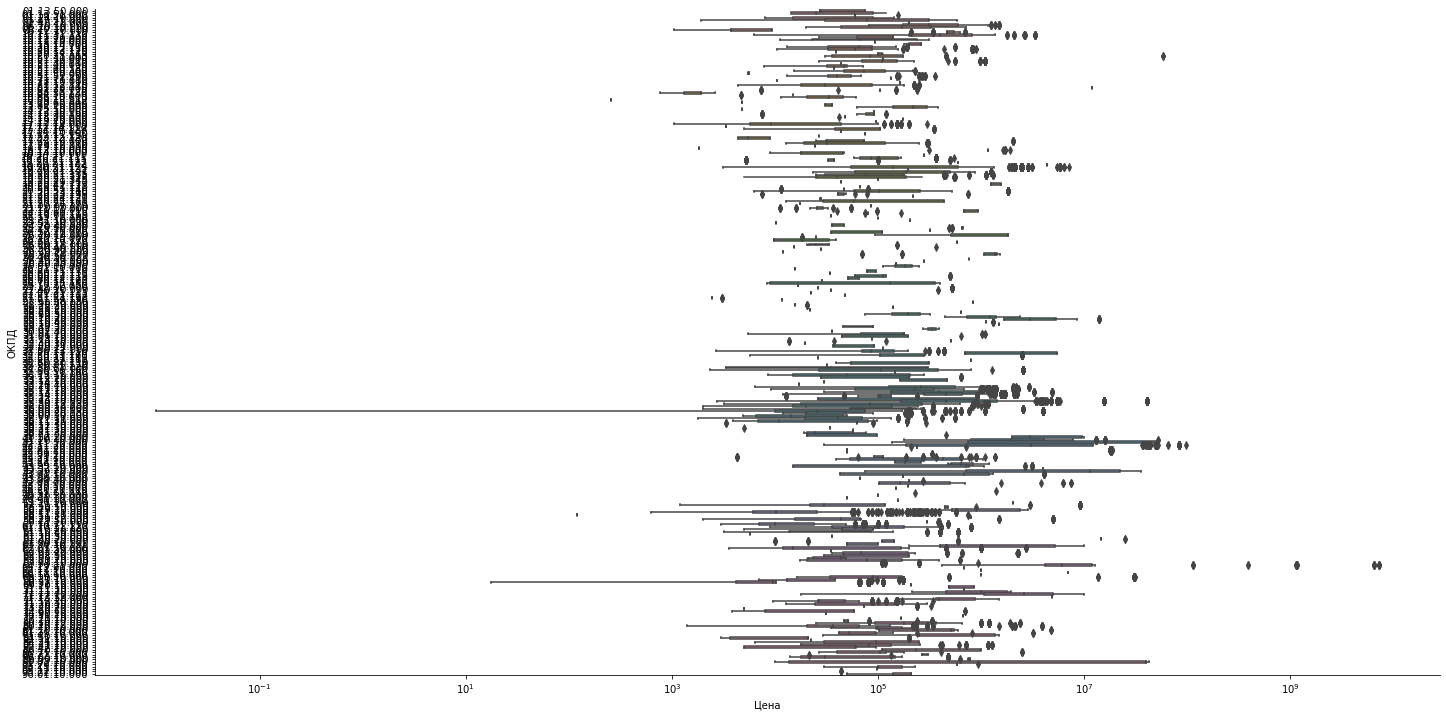

In [ ]:
with sbs.plotting_context(font_scale=1.6):
  data_to_plot = data.filter(['OKPD', 'total'], axis=1).sort_values('OKPD')
  g = sbs.catplot(y = 'OKPD', x = 'total', kind ='box', height = 10, aspect = 2, data = data_to_plot, orient = 'h')
  g.set(xscale = 'log', xlabel = 'Цена', ylabel = 'ОКПД')
  
del data_to_plot
del g
gc.collect()

In [ ]:
len(data['customer_legal_form'].unique())

9

79

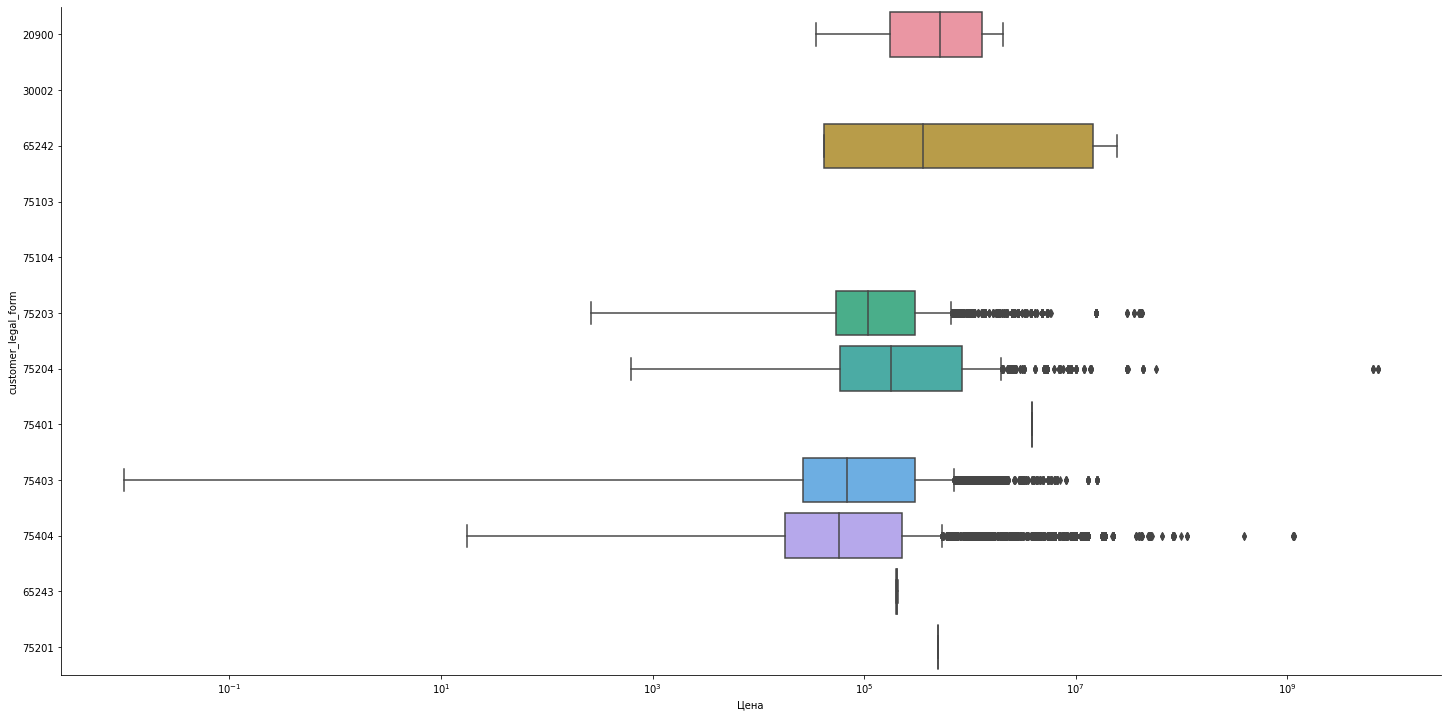

In [ ]:
with sbs.plotting_context(font_scale=1.6):
  data_to_plot = data.filter(['customer_legal_form', 'total'], axis=1).sort_values('customer_legal_form')
  g = sbs.catplot(y = 'customer_legal_form', x = 'total', kind ='box', height = 10, aspect = 2, data = data_to_plot, orient = 'h')
  g.set(xscale = 'log', xlabel = 'Цена', ylabel = 'customer_legal_form')
  
del data_to_plot
del g
gc.collect()

#Прогноз цены

In [ ]:
cat_var = ['plan_number', 
          'customer_legal_form', 
          'positionNumber', 
          'publicDiscussion',
          'isEnergyServiceContract',
          'OKPD',
          'KTRU']

In [ ]:
def errors(model, x_test, y_test):
  outputs = model.predict(x_test)
  error = np.absolute(outputs - y_test) * test_max
  mae = np.sum(error) / len(error)
  error = ((outputs - y_test)**2) * test_max
  mse = np.sum(error) / len(error)
  print("R2:", metrics.r2_score(outputs, y_test))
  print("MAE:", mae) #абсолютная ошибка (MAE)
  print("MSE:", mse) #среднеквадратичная ошибка (MSE)
  print("RMSE:", np.sqrt(mse)) #корень среднеквадратичной ошибки (RMSE)

In [ ]:
x = data.drop(['positionCanceled', 'total'], axis=1)
y = data['total']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle = False)

In [ ]:
print(len(x_train))
print(len(y_train))

39363
39363


In [ ]:
cat_features = cat_var
model_catboost = CatBoostRegressor(
    n_estimators = 1000,
    learning_rate = 0.01,
    max_depth = 16,
    task_type="GPU",
    devices='0:1',
).fit(x_train, y_train, cat_features,
      eval_set=(x_test, y_test),
             use_best_model=True,
             verbose=False)
errors(model_catboost, x_test, y_test)

In [ ]:
enc = LabelEncoder()
for param in cat_var:
  x_train[param] = enc.fit_transform(x_train[param])
  x_test[param] = enc.fit_transform(x_test[param])
x_train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,plan_number,customer_legal_form,positionNumber,publicDiscussion,isEnergyServiceContract,time,OKPD,KTRU
0,0,7,0,0,0,44,239,0
1,41,7,183,0,0,31,129,0
2,37,7,117,0,0,365,56,63
3,41,7,184,0,0,365,182,5
4,41,7,183,0,0,31,129,0


In [ ]:
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
test_max = np.max(y_test)
train_max = np.max(y_train)

gc.collect()

296

In [ ]:
rf_model = RandomForestRegressor(n_estimators=1000, 
                               bootstrap = True,
                               warm_start = True,
                               oob_score = True)
rf_model.fit(x_train, y_train.ravel())
errors(rf_model, x_test, y_test.ravel())

R2: -574426.2919836317
MAE: 0.02627075667516478
MSE: 0.012580815470335972
RMSE: 0.11216423436343678


In [ ]:
model = XGBRegressor(seed=42,
                      n_estimators=1000,
                      max_depth=16,
                      learning_rate=0.01)
model.fit(x_train, y_train.ravel())
errors(model, x_test, y_test.ravel())

[14:05:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2: -643500.6753118397
MAE: 0.026248819858801824
MSE: 0.012579159019027538
RMSE: 0.11215685007625499


In [ ]:
#значимость признаков для леса
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
col = ['plan_number',	'customer_legal_form',	'positionNumber',	'publicDiscussion',	'isEnergyServiceContract',	'time',	'OKPD', 'KTRU']
ar_f=[]
for f, idx in enumerate(indices):
    ar_f.append([round(importances[idx],4), col[idx]])
print("Значимость признака:")
ar_f.sort(reverse=True)
ar_f

Значимость признака:


[[0.9071, 'positionNumber'],
 [0.0793, 'plan_number'],
 [0.0125, 'time'],
 [0.0009, 'OKPD'],
 [0.0002, 'customer_legal_form'],
 [1e-04, 'KTRU'],
 [0.0, 'publicDiscussion'],
 [0.0, 'isEnergyServiceContract']]

In [ ]:
def normalize(y):
  max = np.max(y)
  return y/max

In [ ]:
x_train[:,0] = normalize(x_train[:,0])
x_train[:,1] = normalize(x_train[:,1])
x_train[:,2] = normalize(x_train[:,2])
x_train[:,5] = normalize(x_train[:,5])
x_train[:,6] = normalize(x_train[:,6])
x_train[:,7] = normalize(x_train[:,7])

x_test[:,0] = normalize(x_test[:,0])
x_test[:,1] = normalize(x_test[:,1])
x_test[:,2] = normalize(x_test[:,2])
x_test[:,5] = normalize(x_test[:,5])
x_test[:,6] = normalize(x_test[:,6])
x_test[:,7] = normalize(x_test[:,7])

In [ ]:
lin_model = LinearRegression()
lin_model.fit(x_train, y_train)
errors(lin_model, x_test, y_test)

R2: -582107.833605254
MAE: 491130.6274452734
MSE: 235188.3696023744
RMSE: 484.9622352331926


In [ ]:
poly_model = LinearRegression()
polynomial_features= PolynomialFeatures(degree=3)
x_train_poly = polynomial_features.fit_transform(x_train)
x_test_poly = polynomial_features.fit_transform(x_test)
poly_model.fit(x_train_poly, y_train)
errors(poly_model, x_test_poly, y_test)

R2: -0.0013227535111628441
MAE: 28001.495454174645
MSE: 593550284560.9375
RMSE: 770422.1469823784


In [ ]:
x_train = np.asarray(x_train).astype(np.float32)
x_test = np.asarray(x_test).astype(np.float32)

# y_train = np.asarray(y_train.reshape(-1,1)).astype(np.float32)
# y_test = np.asarray(y_test.reshape(-1,1)).astype(np.float32)

In [ ]:
batch_size = 10
epochs = 10
learning_rate = 0.01

loss = "mean_squared_error"
optimizer = optimizers.SGD(lr = learning_rate)

In [ ]:
model = Sequential()
model.add(Dense(units = 30, activation = "sigmoid", input_dim=8, use_bias=True))
model.add(Dense(units = 30, activation = "sigmoid", use_bias=True))
model.add(Dense(units = 30, activation = "sigmoid", use_bias=True))
model.add(Dense(units = 1,  activation = "sigmoid"))

model.compile(loss = loss,
              optimizer = optimizer,
              metrics = ["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 2,161
Trainable params: 2,161
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train,y_train,
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 1,
                    validation_data = (x_test,y_test),
                    callbacks=None)

score = model.evaluate(x_test,y_test,verbose = 1)
print("test loss:",score[0])
print("test accuracy:",score[1])

Epoch 1/10
3937/3937 [==============================] - 5s 1ms/step - loss: 0.0411 - accuracy: 0.0000e+00 - val_loss: 0.0119 - val_accuracy: 0.0000e+00
Epoch 2/10
3937/3937 [==============================] - 4s 1ms/step - loss: 0.0010 - accuracy: 0.0000e+00 - val_loss: 0.0120 - val_accuracy: 0.0000e+00
Epoch 3/10
3937/3937 [==============================] - 4s 1ms/step - loss: 5.9822e-04 - accuracy: 0.0000e+00 - val_loss: 0.0120 - val_accuracy: 0.0000e+00
Epoch 4/10
3937/3937 [==============================] - 4s 1ms/step - loss: 6.0495e-04 - accuracy: 0.0000e+00 - val_loss: 0.0121 - val_accuracy: 0.0000e+00
Epoch 5/10
3937/3937 [==============================] - 4s 1ms/step - loss: 3.7188e-04 - accuracy: 0.0000e+00 - val_loss: 0.0121 - val_accuracy: 0.0000e+00
Epoch 6/10
3937/3937 [==============================] - 4s 1ms/step - loss: 5.0605e-04 - accuracy: 0.0000e+00 - val_loss: 0.0122 - val_accuracy: 0.0000e+00
Epoch 7/10
3937/3937 [==============================] - 4s 1ms/step - lo

In [ ]:
test_max*0.0122

228066.50720000002

#Перевод y в бинарное число и использование нейронной сети

In [ ]:
d = {'0': [], '1': [], '3': [], 
     '4': [], '5': [], '6': [], 
     '7': [], '8': [], '9': [], 
     '10': [], '11': [], '12': [], 
     '13': [], '14': [], '15': [], 
     '16': [], '17': [], '18': [], 
     '19': [], '20': [], '21': [], 
     '21': [], '22': [], '23': [], 
     '24': [], '25': [], '26': [], 
     '27': [], '28': [], '29': [], 
     '30': [], '31': [], '32': []}
y_vector = pd.DataFrame(data=d)

for i, elem in enumerate(y_train):
  for el, num in zip(bin(int(elem)).replace("0b", "")[::-1], y_vector.columns[::-1]):
    y_vector.loc[i,num] = int(el)

y_vector.iloc[pd.isnull(y_vector)] = 0

y_vector

,0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
39359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
39360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
39361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [ ]:
y_vector_test = pd.DataFrame(data=d)

for i, elem in enumerate(y_test):
  for el, num in zip(bin(int(elem)).replace("0b", "")[::-1], y_vector_test.columns[::-1]):
    y_vector_test.loc[i,num] = int(el)

y_vector_test.iloc[pd.isnull(y_vector_test)] = 0

y_vector_test

,0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
batch_size = 10
epochs = 10
learning_rate = 0.01

loss = "categorical_crossentropy"
optimizer = optimizers.Adam(lr = learning_rate)

In [ ]:
model = Sequential()
model.add(Dense(units = 40, activation = "sigmoid", input_dim=8, use_bias=False))
model.add(Dense(units = 40, activation = "sigmoid", use_bias=False))
model.add(Dense(units = 40, activation = "relu", use_bias=False))
model.add(Dense(units = 32,  activation = "softmax"))

model.compile(loss = loss,
              optimizer = optimizer,
              metrics = ["accuracy"])

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_94 (Dense)             (None, 40)                320       
_________________________________________________________________
dense_95 (Dense)             (None, 40)                1600      
_________________________________________________________________
dense_96 (Dense)             (None, 40)                1600      
_________________________________________________________________
dense_97 (Dense)             (None, 32)                1312      
Total params: 4,832
Trainable params: 4,832
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train,y_vector,
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 1,
                    validation_data = (x_test,y_vector_test),
                    callbacks=None)

score = model.evaluate(x_test,y_vector_test,verbose = 1)
print("test loss:",score[0])
print("test accuracy:",score[1])

Epoch 1/10
3937/3937 [==============================] - 14s 4ms/step - loss: 17293.9169 - accuracy: 0.0260 - val_loss: 63798.8242 - val_accuracy: 0.0774
Epoch 2/10
3937/3937 [==============================] - 13s 3ms/step - loss: 177803.2954 - accuracy: 0.0302 - val_loss: 204401.4531 - val_accuracy: 0.1871
Epoch 3/10
3937/3937 [==============================] - 14s 3ms/step - loss: 469587.6580 - accuracy: 0.0288 - val_loss: 400185.2188 - val_accuracy: 0.0101
Epoch 4/10
3937/3937 [==============================] - 13s 3ms/step - loss: 866692.7593 - accuracy: 0.0308 - val_loss: 661641.0000 - val_accuracy: 0.0047
Epoch 5/10
3937/3937 [==============================] - 13s 3ms/step - loss: 1392773.4147 - accuracy: 0.0327 - val_loss: 972148.0000 - val_accuracy: 0.1871
Epoch 6/10
3937/3937 [==============================] - 13s 3ms/step - loss: 2018974.4656 - accuracy: 0.0314 - val_loss: 1361612.2500 - val_accuracy: 0.0000e+00
Epoch 7/10
3937/3937 [==============================] - 13s 3ms/s

In [ ]:
#RMSprop
bin_error(model.predict(x_test), y_test)
print(get_num(model.predict(x_test))[5])
y_test[5]

R2: 0.0
MAE: 9315950148213.297
MSE: 8.231893155364395e+19
RMSE: 9072978097.275665
256.0


46751.84

In [ ]:
#Adam
bin_error(model.predict(x_test), y_test)
print(get_num(model.predict(x_test))[5])
y_test[5]

R2: 0.0
MAE: 9245948137952.672
MSE: 8.22476608373097e+19
RMSE: 9069049610.477919
4096.0


46751.84

In [ ]:
def get_num(bin_pred):
  y_pred = np.array([])
  for pred in bin_pred:
    y_pred = np.concatenate((y_pred, [int(np.array2string(pred.astype('int'), separator = '').replace("[", "").replace("]", ""), 2)]), axis=0)
  return y_pred

def bin_error(bin_pred, y_test):
  y_pred = get_num(bin_pred)
  error = np.absolute(y_pred - y_test) * test_max
  mae = np.sum(error) / len(error)
  error = ((y_pred - y_test)**2) * test_max
  mse = np.sum(error) / len(error)
  print("R2:", metrics.r2_score(y_pred, y_test))
  print("MAE:", mae) #абсолютная ошибка (MAE)
  print("MSE:", mse) #среднеквадратичная ошибка (MSE)
  print("RMSE:", np.sqrt(mse)) #корень среднеквадратичной ошибки (RMSE)